In [1]:
! pip install sentence_transformers

In [2]:
!pip install ipython-autotime

In [3]:
%load_ext autotime

time: 233 µs (started: 2023-09-03 16:10:04 +00:00)


In [4]:
# Standard libraries
import os, sys, math, random, re, logging

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Machine learning utilities
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch for deep learning
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

# Sentence Transformers for NLP tasks
from sentence_transformers import (
    SentenceTransformer,
    models,
    util,
    losses,
    LoggingHandler,
    evaluation,
    InputExample,
)

from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator



time: 3.24 s (started: 2023-09-03 16:10:04 +00:00)


# **Check Environment Versions**

In [5]:
print("Python:".ljust(10), sys.version[0:6])
print("NumPy:".ljust(10), np.__version__)
print("Pandas:".ljust(10), pd.__version__)
print("Torch:".ljust(10), torch.__version__)
print("Sklearn:".ljust(10), sklearn.__version__)

Python:    3.10.1
NumPy:     1.23.5
Pandas:    1.5.3
Torch:     2.0.1+cu118
Sklearn:   1.2.2
time: 921 µs (started: 2023-09-03 16:10:07 +00:00)


In [6]:
!pip install -q opendatasets

time: 4.42 s (started: 2023-09-03 16:10:07 +00:00)


In [7]:
import opendatasets as od

time: 18.6 ms (started: 2023-09-03 16:10:12 +00:00)


In [8]:
od.download('https://www.kaggle.com/datasets/quora/question-pairs-dataset')

Skipping, found downloaded files in "./question-pairs-dataset" (use force=True to force download)
time: 889 µs (started: 2023-09-03 16:10:12 +00:00)


In [9]:
# Define columns to use and their types
COLUMN_CONFIG = {
    'qid1': np.int32,
    'qid2': np.int32,
    'question1': str,
    'question2': str,
    'is_duplicate': np.int32
}

# Read CSV with only necessary columns and specified types
data = pd.read_csv(
    '/content/question-pairs-dataset/questions.csv',
    usecols=COLUMN_CONFIG.keys(),
    dtype=COLUMN_CONFIG
)


time: 1.06 s (started: 2023-09-03 16:10:12 +00:00)


In [10]:
data.rename(
    columns={
        'question1': 'q1',
        'question2': 'q2',
        'is_duplicate': 'labels'
    },
    inplace=True
)


time: 1.2 ms (started: 2023-09-03 16:10:13 +00:00)


In [11]:
# Remove rows with missing values and duplicates, then display the info
data = data.dropna().drop_duplicates()
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 404348 entries, 0 to 404350
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   qid1    404348 non-null  int32 
 1   qid2    404348 non-null  int32 
 2   q1      404348 non-null  object
 3   q2      404348 non-null  object
 4   labels  404348 non-null  int32 
dtypes: int32(3), object(2)
memory usage: 13.9+ MB
time: 673 ms (started: 2023-09-03 16:10:13 +00:00)


# **Visualizing Length Distribution of First Question by Class**

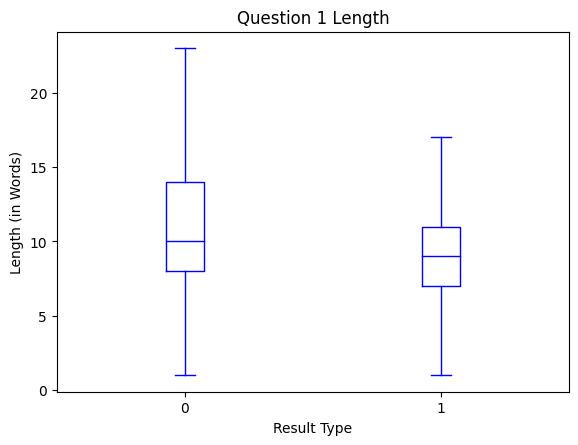

time: 2.09 s (started: 2023-09-03 16:10:13 +00:00)


In [12]:
# Calculate the length of the first question in words and store it in a new column 'q1_len'
data['q1_len'] = data['q1'].str.split().apply(len)

# Generate the boxplot for visualizing 'q1_len' by class ('labels')
data.boxplot(column="q1_len", by="labels", grid=False, showfliers=False, color="blue")

# Customize the plot titles and labels
plt.suptitle('')
plt.title('Question 1 Length')
plt.xlabel('Result Type')
plt.ylabel('Length (in Words)')

# Display the plot
plt.show()



In [13]:
# Group by 'labels' and calculate min, max, and mean of 'q1_len'
stats = data.groupby('labels')['q1_len'].agg(['min', 'max', 'mean'])

# Print the statistics
print(f"Minimum lengths by class: {stats['min'].to_dict()}")
print(f"Maximum lengths by class: {stats['max'].to_dict()}")
print(f"Average lengths by class: {stats['mean'].to_dict()}")


Minimum lengths by class: {0: 1, 1: 1}
Maximum lengths by class: {0: 125, 1: 80}
Average lengths by class: {0: 11.582692262450891, 1: 9.847092548189623}
time: 19.5 ms (started: 2023-09-03 16:10:16 +00:00)


In [14]:
# Remove the temporary 'q1_len' column
data.drop(columns=['q1_len'], inplace=True)


time: 15.7 ms (started: 2023-09-03 16:10:16 +00:00)


# **Visualizing Length of Second Question by Class**

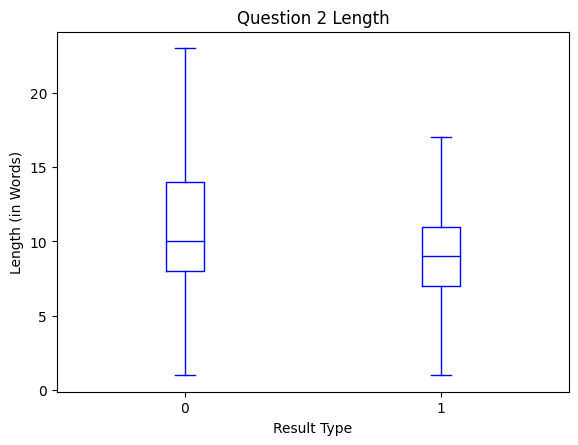

time: 1.82 s (started: 2023-09-03 16:10:16 +00:00)


In [15]:
# Add length of Question 2 as a new column
data['q2_len'] = data['q2'].str.split().apply(len)

# Create the boxplot for Question 2 length, grouped by labels
ax = data.boxplot(column="q2_len", by="labels", grid=False, showfliers=False, color="Blue")
plt.suptitle('')
ax.set_title('Question 2 Length')
ax.set_xlabel('Result Type')
ax.set_ylabel('Length (in Words)')
plt.show()




In [16]:
# Group by 'labels' and calculate min, max, and mean of 'q2_len'
stats_q2 = data.groupby('labels')['q2_len'].agg(['min', 'max', 'mean'])

# Print the statistics for Question 2
print(f"Minimum lengths of Question 2 by class: {stats_q2['min'].to_dict()}")
print(f"Maximum lengths of Question 2 by class: {stats_q2['max'].to_dict()}")
print(f"Average lengths of Question 2 by class: {stats_q2['mean'].to_dict()}")


Minimum lengths of Question 2 by class: {0: 1, 1: 1}
Maximum lengths of Question 2 by class: {0: 237, 1: 60}
Average lengths of Question 2 by class: {0: 11.955015252389803, 1: 9.85926218638233}
time: 13 ms (started: 2023-09-03 16:10:17 +00:00)


In [17]:
# Remove the temporary column 'q2_len'
data.drop(columns=['q2_len'], inplace=True)

time: 14.7 ms (started: 2023-09-03 16:10:17 +00:00)


# **Visualizing Class Distribution with Bar Plot**

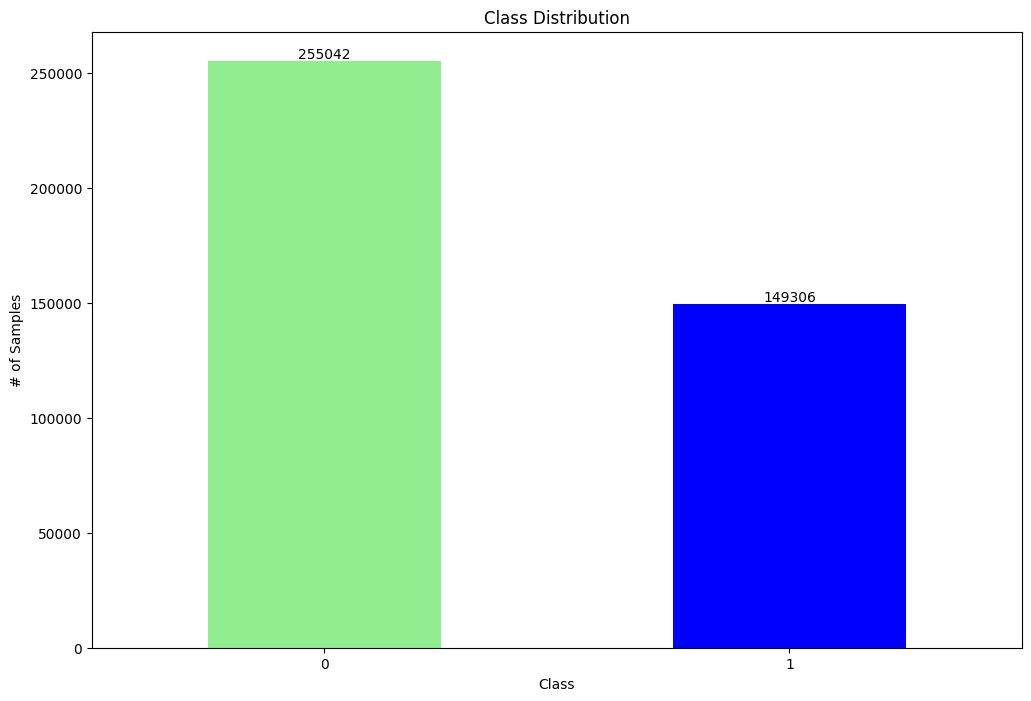

time: 168 ms (started: 2023-09-03 16:10:17 +00:00)


In [18]:
# Variables to configure the plot
feature_to_visualize = data["labels"]
plot_title = "Class Distribution"
x_label = "Class"
y_label = "# of Samples"
rotation = 0
annotations = True

# Create the plot
ax = feature_to_visualize.value_counts().plot.bar(
    figsize=(12, 8),
    rot=rotation,
    color=[
        "lightgreen", "blue", "brown", "lightblue", "tan",
        "yellow", "orange", "green", "red", "purple"
    ]
)

# Annotate bars if enabled
if annotations:
    ax.bar_label(ax.containers[0])

# Configure the plot
plt.title(plot_title)
plt.ylabel(y_label)
plt.xlabel(x_label)

# Show the plot
plt.show()


# **Splitting the Data into Train, Test, Val**

In [19]:
# First, split data into training and temp (evaluation + test) sets
train_ds, temp_ds = train_test_split(data, test_size=0.3, random_state=42)

# Second, split temp into evaluation and test sets
eval_ds, test_ds = train_test_split(temp_ds, test_size=0.5, random_state=42)

print(f"Training Data Shape: {train_ds.shape}")
print(f"Evaluation Data Shape: {eval_ds.shape}")
print(f"Test Data Shape: {test_ds.shape}")

Training Data Shape: (283043, 5)
Evaluation Data Shape: (60652, 5)
Test Data Shape: (60653, 5)
time: 134 ms (started: 2023-09-03 16:10:18 +00:00)


In [20]:
# Configure logging settings
logging.basicConfig(
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO,
    handlers=[LoggingHandler()]
)

# Instantiate logger
logger = logging.getLogger(__name__)

time: 474 µs (started: 2023-09-03 16:10:18 +00:00)


# **Encode Dataset & Instantiate the Model**

In [27]:
model_ckpt = "sentence-transformers/sentence-t5-large"
device=torch.device("cuda")

model = SentenceTransformer(model_ckpt, device=device)
model.max_seq_length = 40

embeddings = model.encode(['q1', 'q2'], show_progress_bar=True)

distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE

margin = 0.50

num_of_epochs = 3

training_batch_size = 8
testing_batch_size = 8

model_save_path = f"{model_ckpt.split('/')[-1]}-quora-sentence_similarity"

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

time: 3.58 s (started: 2023-09-03 16:13:30 +00:00)


# **Note**

1. The purpose of the margin is to specify how far apart the model should aim to place embeddings of different classes in the embedded space.
2. defines the "gap" that we want to enforce between the dissimilar sentences.
3. If the margin is set to 0.5, then the loss function will aim to make the cosine similarity of dissimilar sentences less than 0.5 (because 1 - 0.5 = 0.5).
4. Too small of a margin, and the model might not be able to differentiate between similar and dissimilar sentences effectively.
5. Too large of a margin, and the model might find the task too challenging and fail to converge.


In [28]:
os.makedirs(model_save_path, exist_ok=True)

time: 899 µs (started: 2023-09-03 16:13:38 +00:00)


# **Assigning Training Samples to Dataloader**

In [29]:
# Create train_samples using list comprehension
train_samples = [
    InputExample(texts=[row['q1'], row['q2']], label=int(row['labels']))
    for _, row in train_ds.iterrows()
]

# Initialize DataLoader and loss function
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=training_batch_size)
train_loss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)



time: 14.1 s (started: 2023-09-03 16:13:41 +00:00)


# **Set Up Validation Dataset**

In [30]:

dev_sentences1 = []
dev_sentences2 = []
dev_labels = []

for index, row in eval_ds.iterrows():
    dev_sentences1.append(row['q1'])
    dev_sentences2.append(row['q2'])
    dev_labels.append(row['labels'])




time: 2.8 s (started: 2023-09-03 16:13:55 +00:00)


# **Create Function to Compute Metrics**

In [31]:
binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1,
                                                                dev_sentences2,
                                                                dev_labels,
                                                                show_progress_bar=True,
                                                                batch_size=testing_batch_size,
                                                                name="quora-sentence-similarity",
                                                                write_csv=True)

time: 3.02 ms (started: 2023-09-03 16:13:58 +00:00)


In [32]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator = binary_acc_evaluator,
          epochs=num_of_epochs,
          warmup_steps=20,
          output_path=model_save_path,
          show_progress_bar=True,
          checkpoint_save_steps=1000,
          checkpoint_save_total_limit=5)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/35381 [00:00<?, ?it/s]

Batches:   0%|          | 0/13267 [00:00<?, ?it/s]

Iteration:   0%|          | 0/35381 [00:00<?, ?it/s]

Batches:   0%|          | 0/13267 [00:00<?, ?it/s]

Iteration:   0%|          | 0/35381 [00:00<?, ?it/s]

Batches:   0%|          | 0/13267 [00:00<?, ?it/s]

time: 4h 59min 59s (started: 2023-09-03 16:13:58 +00:00)


# **Eval Results**

In [37]:
from huggingface_hub import HfApi
api = HfApi()

time: 584 µs (started: 2023-09-03 21:39:13 +00:00)


In [40]:
api.create_repo("DrishtiSharma/sentence-t5-large-quora-text-similarity")

RepoUrl('https://huggingface.co/DrishtiSharma/sentence-t5-large-quora-text-similarity', endpoint='https://huggingface.co', repo_type='model', repo_id='DrishtiSharma/sentence-t5-large-quora-text-similarity')

time: 543 ms (started: 2023-09-03 21:40:55 +00:00)


In [41]:
api.upload_folder(
    folder_path = "./sentence-t5-large-quora-text-similarity",
    path_in_repo = ".",
    repo_id = "DrishtiSharma/sentence-t5-large-quora-text-similarity",
    repo_type = "model"
                  )


pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

'https://huggingface.co/DrishtiSharma/sentence-t5-large-quora-text-similarity/tree/main/.'

time: 2min 15s (started: 2023-09-03 21:41:38 +00:00)


In [43]:
# Load the model
model = SentenceTransformer('/content/sentence-t5-large-quora-text-similarity')



time: 3.5 s (started: 2023-09-03 21:53:55 +00:00)


In [44]:
from sklearn.metrics.pairwise import cosine_similarity

time: 369 µs (started: 2023-09-03 21:54:17 +00:00)


In [46]:
# Sentences to be compared
sentences = ["I'm Drishti.", "My name is Drishti."]

# Encode the sentences to get their embeddings
embeddings = model.encode(sentences)

# Reshape the vectors to 2D arrays
emb1 = np.array(embeddings[0]).reshape(1, -1)
emb2 = np.array(embeddings[1]).reshape(1, -1)

# Compute the similarity score
similarity_score = cosine_similarity(emb1, emb2)[0][0]

print(f"The similarity score is: {similarity_score}")

The similarity score is: 0.9076928496360779
time: 37.1 ms (started: 2023-09-03 21:55:01 +00:00)
